## Regression with Amazon SageMaker Linear Learner algorithm
_**Single machine training for regression with Amazon SageMaker Linear Learner algorithm**_

---

---
## Contents
1. [Introduction](#Introduction)
2. [Setup](#Setup)
   1. [Exploring the dataset](#Exploring-the-dataset)
3. [Training the Linear Learner model](#Training-the-Linear-Learner-model)
4. [Set up hosting for the model](#Set-up-hosting-for-the-model)
5. [Inference](#Inference)
6. [Delete the Endpoint](#Delete-the-Endpoint)
7. [Appendix](#Appendix)
  1. [Downloading the dataset](#Downloading-the-dataset)
  2. [libsvm to csv convertion](#libsvm-to-csv-convertion)
  3. [Dividing the data](#Dividing-the-data)
  4. [Data Ingestion](#Data-ingestion)
---
## Introduction

This notebook demonstrates the use of Amazon SageMaker’s implementation of the Linear Learner algorithm to train and host a regression model. We use the [Abalone data](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/regression.html) originally from the [UCI data repository](https://archive.ics.uci.edu/ml/datasets/abalone). 

The dataset contains 9 fields, starting with the Rings number which is a number indicating the age of the abalone (as age equals to number of rings plus 1.5). Usually the number of rings are counted through microscopes to estimate the abalone's age. So we will use our algorithm to predict the abalone age based on the other features which are mentioned respectively as below within the dataset. 

'Rings','sex','Length','Diameter','Height','Whole Weight','Shucked Weight','Viscera Weight' and 'Shell Weight'

The above features starting from sex to Shell.weight are physical measurements that can be measured using the correct tools, so we improve the complixety of having to examine the abalone under microscopes to understand it's age.


---
## Setup


This notebook was tested in Amazon SageMaker Studio on a ml.t3.medium instance with Python 3 (Data Science) kernel.

Let's start by specifying:
1. The S3 buckets and prefixes that you want to use for training data and model data. This should be within the same region as the Notebook Instance, training, and hosting.
1. The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these. Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

In [2]:
import os
import boto3
import re
import sagemaker


role = sagemaker.get_execution_role()
region = boto3.Session().region_name

# S3 bucket for training data.
# Feel free to specify a different bucket and prefix.
data_bucket = f"sagemaker-sample-files"
data_prefix = "datasets/tabular/uci_abalone"


# S3 bucket for saving code and model artifacts.
# Feel free to specify a different bucket and prefix
output_bucket = sagemaker.Session().default_bucket()
output_prefix = "sagemaker/DEMO-linear-learner-abalone-regression"

## Exploring the dataset

We pre-processed the Abalone dataset [1] and stored in a S3 bucket. It was downloaded from the [National Taiwan University's CS department's tools for regression on the abalone dataset](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/regression/abalone). Scripts used in downloading and pre-processing can be found in the [Appendix](#Appendix). These include downloading data, converting data from libsvm format to csv format, dividing it into train, validation and test and uploading it to S3 bucket. 

The dataset contains a total of 9 fields. Throughout this notebook, they will be named as follows 'age','sex','Length','Diameter','Height','Whole.weight','Shucked.weight','Viscera.weight' and 'Shell.weight' respictively.

the below data frame representation explain the value of each field.
Note: the age field is in integer representation and the rest of the features are in the format of "feature_number":"feature_value"

```
**'data.frame'**:
age              int  15 7 9 10 7 8 20 16 9 19 ...
Sex               <feature_number>: Factor w/ 3 levels "F","I","M" values of 1,2,3
Length            <feature_number>: float  0.455 0.35 0.53 0.44 0.33 0.425 ...
Diameter          <feature_number>: float  0.365 0.265 0.42 0.365 0.255 0.3 ...
Height            <feature_number>: float  0.095 0.09 0.135 0.125 0.08 0.095 ...
Whole.weight      <feature_number>: float  0.514 0.226 0.677 0.516 0.205 ...
Shucked.weight    <feature_number>: float  0.2245 0.0995 0.2565 0.2155 0.0895 ...
Viscera.weight    <feature_number>: float  0.101 0.0485 0.1415 0.114 0.0395 ...
Shell.weight      <feature_number>: float  0.15 0.07 0.21 0.155 0.055 0.12 ...
```
>[1] Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

In [2]:
import boto3

s3 = boto3.client("s3")

FILE_TRAIN = "abalone_dataset1_train.csv"
FILE_TEST = "abalone_dataset1_test.csv"
FILE_VALIDATION = "abalone_dataset1_validation.csv"

# downloading the train, test, and validation files from data_bucket
s3.download_file(data_bucket, f"{data_prefix}/train_csv/{FILE_TRAIN}", FILE_TRAIN)
s3.download_file(data_bucket, f"{data_prefix}/test_csv/{FILE_TEST}", FILE_TEST)
s3.download_file(data_bucket, f"{data_prefix}/validation_csv/{FILE_VALIDATION}", FILE_VALIDATION)
s3.upload_file(FILE_TRAIN, output_bucket, f"{output_prefix}/train/{FILE_TRAIN}")
s3.upload_file(FILE_TEST, output_bucket, f"{output_prefix}/test/{FILE_TEST}")
s3.upload_file(FILE_VALIDATION, output_bucket, f"{output_prefix}/validation/{FILE_VALIDATION}")

In [11]:
import pandas as pd  # Read in csv and store in a pandas dataframe

df = pd.read_csv(
    FILE_TRAIN,
    sep=",",
    encoding="latin1",
    names=[
        "age",
        "sex",
        "Length",
        "Diameter",
        "Height",
        "Whole.weight",
        "Shucked.weight",
        "Viscera.weight",
        "Shell.weight",
    ],
)
print(df.head(5))

   age  sex  Length  Diameter  Height  Whole.weight  Shucked.weight  \
0    8    2   0.615     0.480   0.160        1.2525          0.5850   
1   16    2   0.630     0.500   0.155        1.0050          0.3670   
2    6    3   0.295     0.220   0.070        0.1260          0.0515   
3    6    3   0.315     0.235   0.075        0.1485          0.0585   
4   10    2   0.695     0.550   0.185        1.6790          0.8050   

   Viscera.weight  Shell.weight  
0          0.2595        0.3300  
1          0.1990        0.3600  
2          0.0275        0.0350  
3          0.0375        0.0425  
4          0.4015        0.3965  


In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import numpy as np

In [32]:
df[df['sex']==3]['age'].max()

21

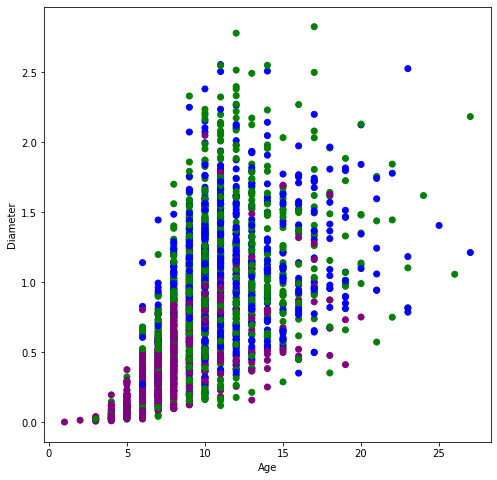

In [43]:

#Male, Female and Infant
colors = {1:'green',2:'blue',3:'purple'}

fig = plt.figure(figsize=(8,8))
plt.scatter(df['age'], df['Whole.weight'], c=df['sex'].map(colors))
plt.xlabel("Age")
plt.ylabel("Diameter")

plt.show()

In [51]:
plt.cm.

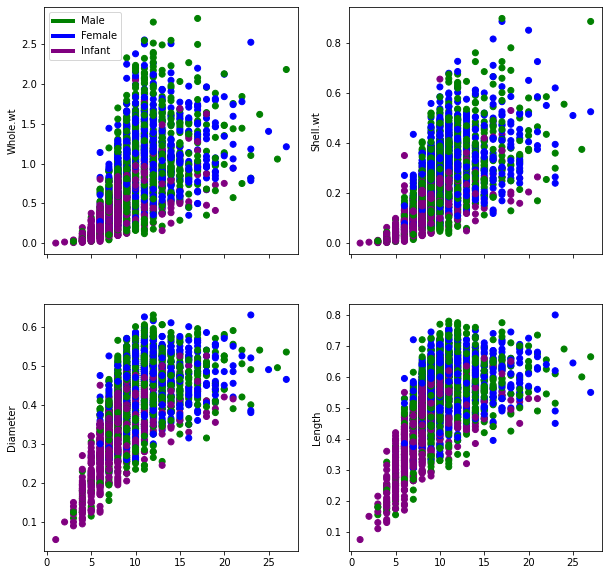

In [60]:

fig, axs = plt.subplots(2, 2,sharex='col', figsize=(10,10))
axs[0,0].scatter(df['age'], df['Whole.weight'], c=df['sex'].map(colors))
axs[0,0].set_ylabel("Whole.wt")

from matplotlib.lines import Line2D
cmap = plt.cm.hsv
custom_lines = [Line2D([0], [0], color="green", lw=4),
                Line2D([0], [0], color="blue", lw=4),
                Line2D([0], [0], color="purple", lw=4)]

axs[0,0].legend(custom_lines, ['Male', 'Female', 'Infant'])

axs[0,1].scatter(df['age'], df['Shell.weight'], c=df['sex'].map(colors))
axs[0,1].set_ylabel("Shell.wt")

axs[1,0].scatter(df['age'], df['Diameter'], c=df['sex'].map(colors))
axs[1,0].set_ylabel("Diameter")

axs[1,1].scatter(df['age'], df['Length'], c=df['sex'].map(colors))
axs[1,1].set_ylabel("Length")

plt.show()


---
Let us prepare the handshake between our data channels and the algorithm. To do this, we need to create the `sagemaker.session.s3_input` objects from our [data channels](https://sagemaker.readthedocs.io/en/v1.2.4/session.html#). These objects are then put in a simple dictionary, which the algorithm consumes. Notice that here we use a `content_type` as `text/csv` for the pre-processed file in the data_bucket. We use two channels here one for training and the second one for validation. The testing samples from above will be used on the prediction step.

In [4]:
# creating the inputs for the fit() function with the training and validation location
s3_train_data = f"s3://{output_bucket}/{output_prefix}/train"
print(f"training files will be taken from: {s3_train_data}")
s3_validation_data = f"s3://{output_bucket}/{output_prefix}/validation"
print(f"validation files will be taken from: {s3_validation_data}")
output_location = f"s3://{output_bucket}/{output_prefix}/output"
print(f"training artifacts output location: {output_location}")

# generating the session.s3_input() format for fit() accepted by the sdk
train_data = sagemaker.inputs.TrainingInput(
    s3_train_data,
    distribution="FullyReplicated",
    content_type="text/csv",
    s3_data_type="S3Prefix",
    record_wrapping=None,
    compression=None,
)
validation_data = sagemaker.inputs.TrainingInput(
    s3_validation_data,
    distribution="FullyReplicated",
    content_type="text/csv",
    s3_data_type="S3Prefix",
    record_wrapping=None,
    compression=None,
)

training files will be taken from: s3://sagemaker-us-east-1-973994155064/sagemaker/DEMO-linear-learner-abalone-regression/train
validation files will be taken from: s3://sagemaker-us-east-1-973994155064/sagemaker/DEMO-linear-learner-abalone-regression/validation
training artifacts output location: s3://sagemaker-us-east-1-973994155064/sagemaker/DEMO-linear-learner-abalone-regression/output


## Training the Linear Learner model

First, we retrieve the image for the Linear Learner Algorithm according to the region.

Then we create an [estimator from the SageMaker Python SDK](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html) using the Linear Learner container image and we setup the training parameters and hyperparameters configuration.


In [5]:
# getting the linear learner image according to the region
from sagemaker.image_uris import retrieve

container = retrieve("linear-learner", boto3.Session().region_name, version="1")
print(container)

382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1


In [6]:
%%time
import boto3
import sagemaker
from time import gmtime, strftime

sess = sagemaker.Session()

job_name = "DEMO-linear-learner-abalone-regression-" + strftime("%H-%M-%S", gmtime())
print("Training job", job_name)

linear = sagemaker.estimator.Estimator(
    container,
    role,
    input_mode="File",
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path=output_location,
    sagemaker_session=sess,
)

linear.set_hyperparameters(
    feature_dim=8,
    epochs=16,
    wd=0.01,
    loss="absolute_loss",
    predictor_type="regressor",
    normalize_data=True,
    optimizer="adam",
    mini_batch_size=100,
    lr_scheduler_step=100,
    lr_scheduler_factor=0.99,
    lr_scheduler_minimum_lr=0.0001,
    learning_rate=0.1,
)

Training job DEMO-linear-learner-abalone-regression-21-53-24
CPU times: user 130 ms, sys: 2.76 ms, total: 133 ms
Wall time: 189 ms


---
After configuring the Estimator object and setting the hyperparameters for this object. The only remaining thing to do is to train the algorithm. The following cell will train the algorithm. Training the algorithm involves a few steps. Firstly, the instances that we requested while creating the Estimator classes are provisioned and are setup with the appropriate libraries. Then, the data from our channels are downloaded into the instance. Once this is done, the training job begins. The provisioning and data downloading will take time, depending on the size of the data. Therefore it might be a few minutes before we start getting data logs for our training jobs. The data logs will also print out Mean Average Precision (mAP) on the validation data, among other losses, for every run of the dataset once or one epoch. This metric is a proxy for the quality of the algorithm.

Once the job has finished a "Job complete" message will be printed. The trained model can be found in the S3 bucket that was setup as output_path in the estimator. For this example,the training time takes between 4 and 6 minutes.


In [7]:
%%time
linear.fit(inputs={"train": train_data, "validation": validation_data}, job_name=job_name)

2021-06-28 21:53:31 Starting - Starting the training job...
2021-06-28 21:53:55 Starting - Launching requested ML instancesProfilerReport-1624917211: InProgress
......
2021-06-28 21:54:55 Starting - Preparing the instances for training.........
2021-06-28 21:56:21 Downloading - Downloading input data...
2021-06-28 21:56:56 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[06/28/2021 21:57:15 INFO 140207338293056] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer':

## Set up hosting for the model

Once the training is done, we can deploy the trained model as an Amazon SageMaker real-time hosted endpoint. This will allow us to make predictions (or inference) from the model. Note that we don't have to host on the same insantance (or type of instance) that we used to train. Training is a prolonged and compute heavy job that require a different of compute and memory requirements that hosting typically do not. We can choose any type of instance we want to host the model. In our case we chose the ml.m4.xlarge instance to train, but we choose to host the model on the less expensive cpu instance, ml.c4.xlarge. The endpoint deployment can be accomplished as follows:


In [8]:
%%time
# creating the endpoint out of the trained model
linear_predictor = linear.deploy(initial_instance_count=1, instance_type="ml.c4.xlarge")
print(f"\ncreated endpoint: {linear_predictor.endpoint_name}")

---------------!
created endpoint: linear-learner-2021-06-28-21-58-27-516
CPU times: user 257 ms, sys: 19.5 ms, total: 277 ms
Wall time: 7min 32s


## Inference

Now that the trained model is deployed at an endpoint that is up-and-running, we can use this endpoint for inference. To do this, we are going to configure the [predictor object](https://sagemaker.readthedocs.io/en/v1.2.4/predictors.html) to parse contents of type text/csv and deserialize the reply received from the endpoint to json format.


In [9]:
# configure the predictor to accept to serialize csv input and parse the reposne as json
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

linear_predictor.serializer = CSVSerializer()
linear_predictor.deserializer = JSONDeserializer()

---
We then use the test file containing the records of the data that we kept to test the model prediction. By running below cell multiple times we are selecting random sample from the testing samples to perform inference with.

In [10]:
%%time
import json
from itertools import islice
import math
import struct
import boto3
import random

# getting testing sample from our test file
test_data = [l for l in open(FILE_TEST, "r")]
sample = random.choice(test_data).split(",")
actual_age = sample[0]
payload = sample[1:]  # removing actual age from the sample
payload = ",".join(map(str, payload))

# Invoke the predicor and analyise the result
result = linear_predictor.predict(payload)

# extracting the prediction value
result = round(float(result["predictions"][0]["score"]), 2)


accuracy = str(round(100 - ((abs(float(result) - float(actual_age)) / float(actual_age)) * 100), 2))
print(f"Actual age: {actual_age}\nPrediction: {result}\nAccuracy: {accuracy}")

Actual age: 9
Prediction: 9.39
Accuracy: 95.67
CPU times: user 12.2 ms, sys: 2.34 ms, total: 14.5 ms
Wall time: 185 ms


## What Can Understand from the model about my data ?

In [62]:
sagemaker.Session().default_bucket()

'sagemaker-us-east-1-973994155064'

In [68]:
!aws s3 ls s3://sagemaker-us-east-1-973994155064/sagemaker/DEMO-linear-learner-abalone-regression/output/DEMO-linear-learner-abalone-regression-21-53-24/output/

2021-06-28 21:57:35        897 model.tar.gz


In [9]:
import os
import mxnet as mx
import boto3
 
bucket = sagemaker.Session().default_bucket()
key = "sagemaker/DEMO-linear-learner-abalone-regression/output/DEMO-linear-learner-abalone-regression-21-53-24/output/model.tar.gz"
boto3.resource('s3').Bucket(bucket).download_file(key, 'model.tar.gz')
 
os.system('tar -zxvf model.tar.gz')
 
# Linear learner model is itself a zip file, containing a mxnet model and other metadata.
# First unzip the model.
os.system('unzip model_algo-1') 
 
# Load the mxnet module
mod = mx.module.Module.load("mx-mod", 0)
 
# model's weights
weights=mod._arg_params['fc0_weight'].asnumpy().flatten()
 
# model bias
intercept=mod._arg_params['fc0_bias'].asnumpy().flatten()

In [15]:
features = [
    "sex",
    "Length",
    "Diameter",
    "Height",
    "Whole.weight",
    "Shucked.weight",
    "Viscera.weight",
    "Shell.weight",
]

## Model Explainability : Weights Sorted

In [20]:
sorted(zip(features, weights),key = lambda x: abs(x[1]))

[('sex', -0.31402323),
 ('Length', 0.5061703),
 ('Viscera.weight', -1.3471746),
 ('Whole.weight', 1.5255507),
 ('Diameter', 7.550051),
 ('Shucked.weight', -10.001843),
 ('Shell.weight', 14.619927),
 ('Height', 16.972511)]

## Delete the Endpoint
Having an endpoint running will incur some costs. Therefore as a clean-up job, we should delete the endpoint.

In [61]:
sagemaker.Session().delete_endpoint(linear_predictor.endpoint_name)
print(f"deleted {linear_predictor.endpoint_name} successfully!")

deleted linear-learner-2021-06-28-21-58-27-516 successfully!


# Appendix : Home Work Review

## Downloading the dataset

We are downloading the dataset in the original libsvm format, more info about this format can be found [here](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/regression.html).

In [ ]:
%%time
s3 = boto3.client("s3")

# Load the dataset
SOURCE_DATA = "abalone"
s3.download_file(data_bucket, f"{data_prefix}/abalone.libsvm", SOURCE_DATA)

## libsvm to csv convertion
Then we convert this dataset into csv format which is one of the accepted formats by the Linear Learner Algorithm, more information [here](https://docs.aws.amazon.com/sagemaker/latest/dg/linear-learner.html#ll-input_output).

The value of the age field is parsed as integer and the value for the features is extracted from the format of "feature_number":"feature_value" to return only the value of the corresponding feature then the final frame is written to the output file.

In [ ]:
%%time

# import numpy and pandas libraries for working with data
import numpy as np
import pandas as pd  # Read in csv and store in a pandas dataframe

df = pd.read_csv(
    SOURCE_DATA,
    sep=" ",
    encoding="latin1",
    names=[
        "age",
        "sex",
        "Length",
        "Diameter",
        "Height",
        "Whole.weight",
        "Shucked.weight",
        "Viscera.weight",
        "Shell.weight",
    ],
)

# converting the age to int value
df["age"] = df["age"].astype(int)

# drop any null values
df.dropna(inplace=True)

# Extracting the features values from  the libsvm format
features = [
    "sex",
    "Length",
    "Diameter",
    "Height",
    "Whole.weight",
    "Shucked.weight",
    "Viscera.weight",
    "Shell.weight",
]
for feature in features:
    if feature == "sex":
        df[feature] = (df[feature].str.split(":", n=1, expand=True)[1]).astype(int)
    else:
        df[feature] = (df[feature].str.split(":", n=1, expand=True)[1]).astype(float)


# #writing the final data in the correct format
df.to_csv("new_data_set_float32.csv", sep=",", index=False, header=None)

print(df.head(1))

## Dividing the data

Following methods split the data into train/test/validation datasets and upload files to S3.


In [ ]:
import io
import boto3
import random


def data_split(
    FILE_DATA,
    FILE_TRAIN,
    FILE_VALIDATION,
    FILE_TEST,
    PERCENT_TRAIN,
    PERCENT_VALIDATION,
    PERCENT_TEST,
):
    data = [l for l in open(FILE_DATA, "r")]
    train_file = open(FILE_TRAIN, "w")
    valid_file = open(FILE_VALIDATION, "w")
    tests_file = open(FILE_TEST, "w")

    num_of_data = len(data)
    num_train = int((PERCENT_TRAIN / 100.0) * num_of_data)
    num_valid = int((PERCENT_VALIDATION / 100.0) * num_of_data)
    num_tests = int((PERCENT_TEST / 100.0) * num_of_data)

    data_fractions = [num_train, num_valid, num_tests]
    split_data = [[], [], []]

    rand_data_ind = 0

    for split_ind, fraction in enumerate(data_fractions):
        for i in range(fraction):
            rand_data_ind = random.randint(0, len(data) - 1)
            split_data[split_ind].append(data[rand_data_ind])
            data.pop(rand_data_ind)

    for l in split_data[0]:
        train_file.write(l)

    for l in split_data[1]:
        valid_file.write(l)

    for l in split_data[2]:
        tests_file.write(l)

    train_file.close()
    valid_file.close()
    tests_file.close()


def write_to_s3(fobj, bucket, key):
    return (
        boto3.Session(region_name=region)
        .resource("s3")
        .Bucket(bucket)
        .Object(key)
        .upload_fileobj(fobj)
    )


def upload_to_s3(bucket, prefix, channel, filename):
    fobj = open(filename, "rb")
    key = f"{prefix}/{channel}/{filename}"
    url = f"s3://{bucket}/{key}"
    print(f"Writing to {url}")
    write_to_s3(fobj, bucket, key)

### Data ingestion

Next, we read the dataset from the existing repository into memory, for preprocessing prior to training. This processing could be done *in situ* by Glue, Amazon Athena, Apache Spark in Amazon EMR, Amazon Redshift, etc., assuming the dataset is present in the appropriate location. Then, the next step would be to transfer the data to S3 for use in training. For small datasets, such as this one, reading into memory isn't onerous, though it would be for larger datasets.

In [ ]:
%%time
# Load the dataset
FILE_DATA = "new_data_set_float32.csv"

# split the downloaded data into train/test/validation files
FILE_TRAIN = "abalone_dataset1_train.csv"
FILE_VALIDATION = "abalone_dataset1_validation.csv"
FILE_TEST = "abalone_dataset1_test.csv"
PERCENT_TRAIN = 70
PERCENT_VALIDATION = 15
PERCENT_TEST = 15
data_split(
    FILE_DATA,
    FILE_TRAIN,
    FILE_VALIDATION,
    FILE_TEST,
    PERCENT_TRAIN,
    PERCENT_VALIDATION,
    PERCENT_TEST,
)

# S3 bucket to store training data.
# Feel free to specify a different bucket and prefix.
bucket = sagemaker.Session().default_bucket()
prefix = "sagemaker/DEMO-linear-learner-abalone-regression"

# upload the files to the S3 bucket
upload_to_s3(bucket, prefix, "train", FILE_TRAIN)
upload_to_s3(bucket, prefix, "validation", FILE_VALIDATION)
upload_to_s3(bucket, prefix, "test", FILE_TEST)